# Variational Quantum classifier to detect credit card fraud 

### **Victor Onofre**

Any sort of ilicit/illegal activity by an individual in order to obatain unauthorized funds using credit card from the account for whom it was not intended to is defined as fradulent activity in credit card transcaction. 

Challenges for fraud detection:

1. Limited number of variables is made available due to high confidentiality.
2. The behaviour and pattern of fraud keeps changing
3. It is requiered to deal with massive amount of data

Classification is one of the widely used techniques for building fraud detection models. Decision trees, Bayesian Classifieres, neural networks, logistic regression, nearest neighbors and support vector machines are the main classification methods that are in use.

In [1]:
import numpy as np 
import pandas as pd 

import warnings 
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

# Part I: Data Exploration

https://www.kaggle.com/mlg-ulb/creditcardfraud

The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [2]:
train=pd.read_csv("creditcard.csv")
train.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
train.shape

(284807, 31)

In [4]:
train.isnull().values.any()

False

In [5]:
train.nunique()

Time      124592
V1        275663
V2        275663
V3        275663
V4        275663
V5        275663
V6        275663
V7        275663
V8        275663
V9        275663
V10       275663
V11       275663
V12       275663
V13       275663
V14       275663
V15       275663
V16       275663
V17       275663
V18       275663
V19       275663
V20       275663
V21       275663
V22       275663
V23       275663
V24       275663
V25       275663
V26       275663
V27       275663
V28       275663
Amount     32767
Class          2
dtype: int64

<AxesSubplot:xlabel='log_Amount', ylabel='Count'>

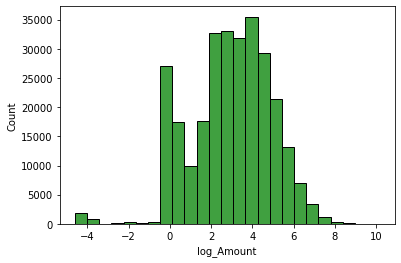

In [6]:
train['log_Amount'] = train['Amount'].apply(lambda x: np.log(x + 0.01))
sns.histplot(train['log_Amount'],bins=25,color="green")

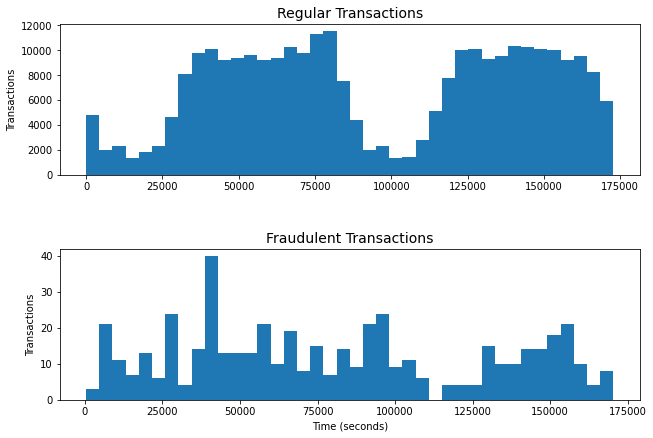

In [7]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 7))

ax[0].hist(train['Time'][train['Class'] == 0], bins=40)
ax[0].set_title('Regular Transactions', fontsize=14)
ax[0].set_ylabel('Transactions')

ax[1].hist(train['Time'][train['Class'] == 1], bins=40)
ax[1].set_title('Fraudulent Transactions', fontsize=14)
ax[1].set_ylabel('Transactions')
ax[1].set_xlabel('Time (seconds)')

plt.tight_layout(pad=4.0)

In [8]:
# robust scaler
scaler=RobustScaler()
train['scaled_Amount']=scaler.fit_transform(train['log_Amount'].values.reshape(-1, 1))
train['scaled_time']=scaler.fit_transform(train['Time'].values.reshape(-1, 1))

<AxesSubplot:xlabel='scaled_Amount', ylabel='Count'>

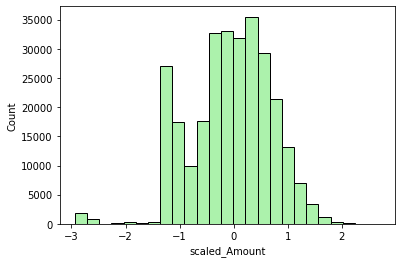

In [9]:
sns.histplot(train['scaled_Amount'],bins=25,color="lightgreen")

<AxesSubplot:xlabel='scaled_time', ylabel='Count'>

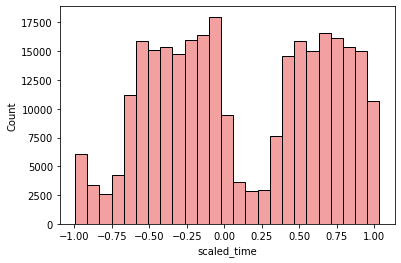

In [10]:
sns.histplot(train['scaled_time'],bins=25,color="lightcoral")

In [11]:
class_count_0, class_count_1 = train['Class'].value_counts()
class_0 = train[train['Class'] == 0]
class_1 = train[train['Class'] == 1]
print('class 0:', class_0.shape)
print('class 1:', class_1.shape)

class 0: (284315, 34)
class 1: (492, 34)


In [12]:
fraud_df=train[train['Class']==1]
non_fraud_df=train[train['Class']==0]
fraud_df.shape, non_fraud_df.shape

((492, 34), (284315, 34))

In [13]:
train.drop(['Time','Amount','log_Amount'], axis=1, inplace=True)

In [14]:
scaled_amount = train['scaled_Amount']
scaled_time = train['scaled_time']

train.drop(['scaled_Amount', 'scaled_time'], axis=1, inplace=True)
train.insert(0, 'scaled_Amount', scaled_amount)
train.insert(1, 'scaled_time', scaled_time)

# Amount and Time are Scaled
train.head()

,scaled_Amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,0.731127,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.800391,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,1.085310,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,0.657947,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.441346,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


## I.I Resampling Techniques for Imbalanced Classes

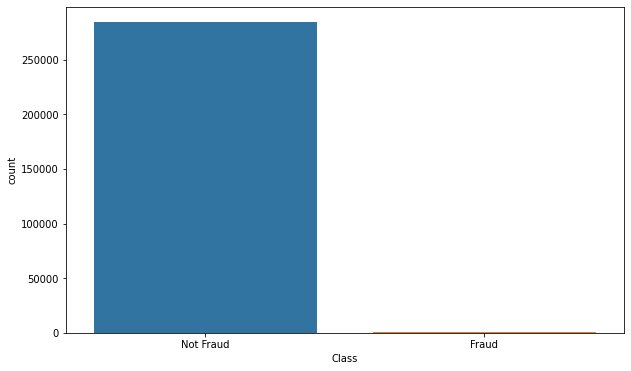

In [15]:
plt.figure(figsize=(10,6))
g = sns.countplot(train['Class'])
g.set_xticklabels(['Not Fraud','Fraud'])
plt.show()

In [16]:
y=train['Class']
train.drop(['Class'],axis=1,inplace=True)

In [17]:
# train test split of the dataset
x_train,x_test,y_train,y_test=train_test_split(train,y,test_size=0.2,random_state=42)

Oversampling can be defined as adding more copies of the minority class. Oversampling can be a good choice when you don’t have a ton of data to work with.

In [18]:
# random over sampler
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)

# fit predictor and target variable
x_ros, y_ros = ros.fit_resample(x_train, y_train)

print('Original dataset shape', Counter(y))
print('Resample dataset shape', Counter(y_ros))

Original dataset shape Counter({0: 284315, 1: 492})
Resample dataset shape Counter({0: 227451, 1: 227451})


<AxesSubplot:xlabel='Class', ylabel='count'>

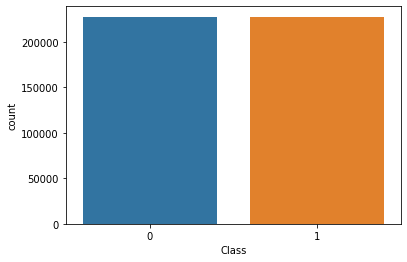

In [19]:
sns.countplot(y_ros)

Undersampling can be defined as removing some observations of the majority class. Undersampling can be a good choice when you have a ton of data -think millions of rows. But a drawback is that we are removing information that may be valuable. This could lead to underfitting and poor generalization to the test set.

In [20]:
# Random under sampler
from imblearn.under_sampling import RandomUnderSampler

ros = RandomUnderSampler(random_state=42)

# fit predictor and target variable
x_rus, y_rus = ros.fit_resample(x_train, y_train)

print('Original dataset shape', Counter(y))
print('Resample dataset shape', Counter(y_rus))

Original dataset shape Counter({0: 284315, 1: 492})
Resample dataset shape Counter({0: 394, 1: 394})


<AxesSubplot:xlabel='Class', ylabel='count'>

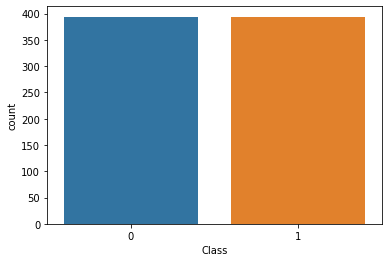

In [21]:
sns.countplot(y_rus)

**SMOTE (Synthetic Minority Over-sampling Technique)**

This technique is followed to avoid overfitting which occurs when exact replicas of minority instances are added to the main dataset. A subset of data is taken from the minority class as an example and then new synthetic similar instances are created. These are not duplicate or replicate of existing minority class data.These synthetic instances are then added to the original dataset.The new dataset is used as a sample to train the classification models.

In [22]:
from imblearn.over_sampling import SMOTE
from sklearn.cluster import KMeans
#from clover.over_sampling import ClusterOverSampler

In [23]:
# smote
oversample = SMOTE()
x_smote, y_smote = oversample.fit_resample(x_train, y_train)
print('original dataset shape:', Counter(y))
print('Resample dataset shape', Counter(y_smote))

original dataset shape: Counter({0: 284315, 1: 492})
Resample dataset shape Counter({0: 227451, 1: 227451})


<AxesSubplot:xlabel='Class', ylabel='count'>

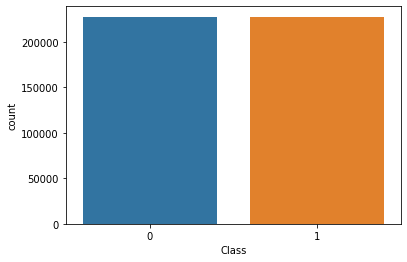

In [24]:
sns.countplot(y_smote)

## Part II: Classical Model building 

### I.III Decision Tree Classifier

A Decision Tree is a simple representation for classifying examples. It is a Supervised Machine Learning where the data is continuously split according to a certain parameter.

In [25]:
from sklearn.metrics import accuracy_score, classification_report,roc_auc_score
# decision Tree Classifier
model_4=DecisionTreeClassifier()
model_4.fit(x_smote,y_smote)
pred_4=model_4.predict(x_test)
acc_4 = accuracy_score(y_test, pred_4)
#con_mat = confusion_matrix(y_test, pred_4)
clf_report = classification_report(y_test, pred_4)
print(f"Accuracy Score of Decision Tree : {acc_4}")
print(f"Classification Report : \n{clf_report}")

Accuracy Score of Decision Tree : 0.9977704434535304
Classification Report : 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.42      0.78      0.54        98

    accuracy                           1.00     56962
   macro avg       0.71      0.89      0.77     56962
weighted avg       1.00      1.00      1.00     56962



In [26]:
# with smote
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,roc_auc_score
model_1=LogisticRegression()
model_1.fit(x_smote,y_smote)
pred_1=model_1.predict(x_test)
acc_1 = accuracy_score(y_test, pred_1)
#con_mat = confusion_matrix(y_test, pred_1)
clf_report = classification_report(y_test, pred_1)
print(f"Accuracy Score of Logistic Regression : {acc_1}")
#print(f"Confusion Matrix : \n{con_mat}")
print(f"Classification Report : \n{clf_report}")

Accuracy Score of Logistic Regression : 0.9746673220743653
Classification Report : 
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.99     56962



In [27]:
#Import Library for Support Vector Machine
from sklearn import svm
from sklearn.metrics import accuracy_score
#Initialize the Support Vector Classifier
model = svm.SVC()

#Train the model using Training Dataset
model.fit(x_smote,y_smote)

# Prediction using test data
y_pred = model.predict(x_test)

# Calculate Model accuracy by comparing y_test and y_pred
acc_svc = round( accuracy_score(y_test, y_pred) * 100, 2 )
print( 'Accuracy of Support Vector Classifier: ', acc_svc )

Accuracy of Support Vector Classifier:  98.37


# Part III: Variational Quantum classifier 

A quantum neural network can broadly be define as a quantum circuit with trainable parameters. This means that a quantum neural network is a variational quantum circuit, a parameterized quantum circuit that can be optimized by training the parameters of the quantum circuit, which are qubit rotations, and the measurement of this circuit will approximate the quantity of interest.

Machine learning techniques are built around:

1. An adaptable system that allows approximation.
2. Calculation of a cost function in the output layer.
3. A way to update the network to minimize the cost function and improve on the model’s ability to perform the machine learning task.

To pursue the task of classification using quantum machine learning, we can use a hybrid neural network based on a quantum variational classifier.

Given a dataset about transactions made by credit cards, can we predict if they are likely be a fraduelent transaction. This is a binary classification problem, with a real input vector x and a binary output y in [0, 1], 0 is a fraudelent transacciont, 1 is not. We want to build a quantum circuit whose output is a quantum state

The dimension of the data corresponds to the number of qubits required in order to encode the data for the quantum feature maps we will later initialize. We cannot work with large number of qubits, therefore I choose to work with data of dimension 30.

In [28]:
x_smote2= x_smote[:30]
y_smote2 = y_smote[:30]

In [29]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit.quantum_info import Statevector

import matplotlib.pyplot as plt

from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

%matplotlib inline

In [30]:
n = 5
LR = 1e-3
class_labels = ['Not_Fraud', 'Fraud']

In [31]:
X, Y = x_smote2[['scaled_Amount', 'V1', 'V2', 'V3', 'V4']].values, y_smote2.values
# normalize the data
X = normalize(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [32]:
sv = Statevector.from_label('0' * n)

## Quantum Feature Map

Let $\chi$ be a set of input data. A feature map $\phi: \chi \rightarrow F$ where $F$ is the featrure space. The outputs of the map on the individual data points, $\phi(x)$ for all $x \in \chi$, are called feature vectors. 

In general $F$ is just a vector space - a quantum feature map $\phi: \chi \rightarrow F$ is a feature map where the vector space $F$ is a Hilbert space and the feature vectors are quantum states. The map transfroms $x \rightarrow |\phi(x)>$ by way of a unitary transformation $U_{\phi}(x)$, which is typically a variational circuit whose parameters depend on the input data.

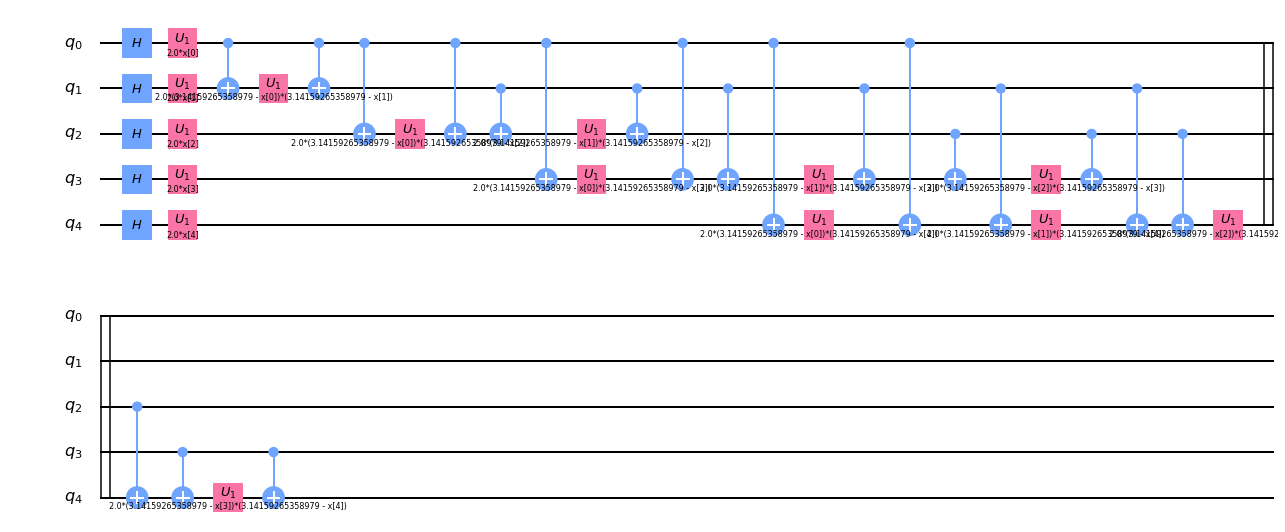

In [33]:
feature_map = ZZFeatureMap(n, reps=1) # Second-order Pauli-Z evolution circuit.
feature_map.draw(output='mpl')

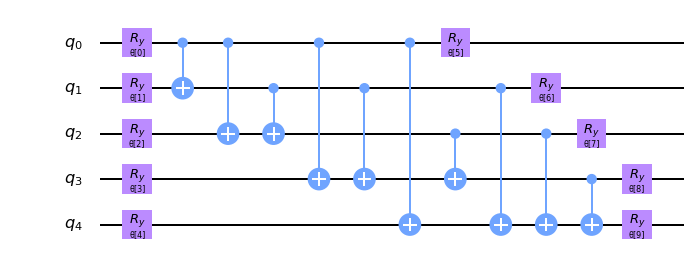

In [34]:
var_form = RealAmplitudes(n, reps=1) # The RealAmplitudes circuit is a heuristic trial wave function used as Ansatz in chemistry applications or classification circuits in machine learning.
var_form.draw(output='mpl')

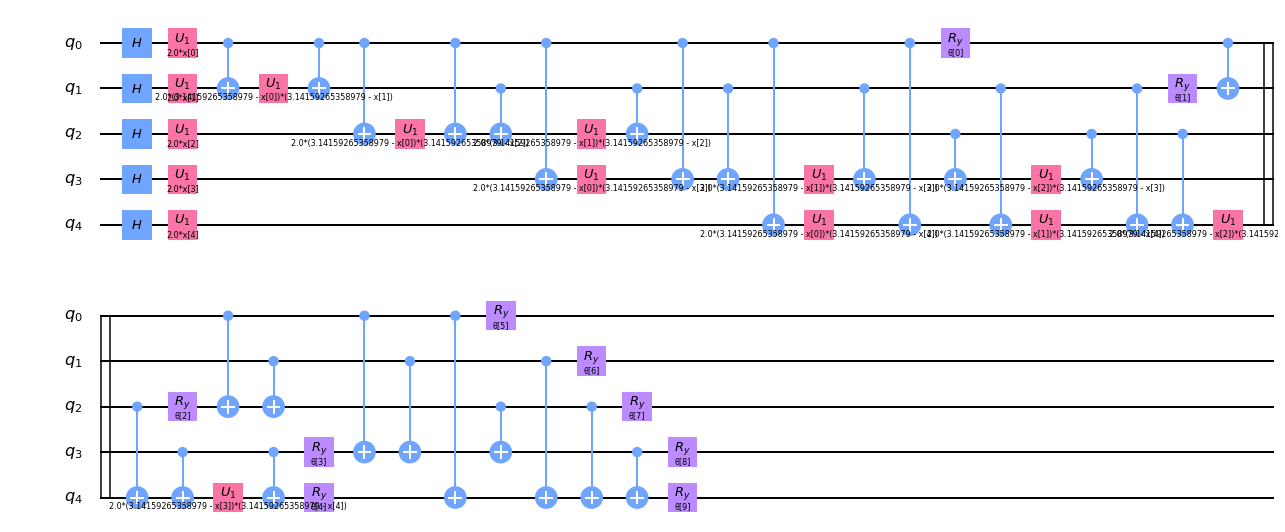

In [35]:
circuit = feature_map.combine(var_form)
circuit.draw(output='mpl')

## **Test of circuits for one set of parameters**

Parameters for testing one iteration of the algorithm 

In [36]:
parameters_test = [0.16905875, 4.6350628 , 4.17091288, 3.23471128, 2.10850903,1.01827162, 0.35361994, 4.84247116, 4.61215744, 4.3947329 ]

In [37]:
feature_map.ordered_parameters

[Parameter(x[0]),
 Parameter(x[1]),
 Parameter(x[2]),
 Parameter(x[3]),
 Parameter(x[4])]

In [38]:
for i, p in enumerate(feature_map.ordered_parameters):
    print(i)
    print(p)

0
x[0]
1
x[1]
2
x[2]
3
x[3]
4
x[4]


In [39]:
# Assign the the data to the featuremap
parameters = {}
for i, p in enumerate(feature_map.ordered_parameters):
    parameters[p] = X_train[i]

In [40]:
parameters

{Parameter(x[0]): array([-0.14570187,  0.94655642, -0.1843605 , -0.15251724,  0.15984871]),
 Parameter(x[1]): array([ 0.01345062, -0.90032795,  0.42420711, -0.09608996, -0.00661145]),
 Parameter(x[2]): array([ 0.01847325,  0.81383143, -0.34741963, -0.36416902, -0.28985803]),
 Parameter(x[3]): array([ 0.14332227, -0.49531742,  0.66148937,  0.39919553,  0.37039723]),
 Parameter(x[4]): array([ 0.45596258,  0.12847039, -0.85550746, -0.2080774 , -0.0201065 ])}

In [41]:
var_form.ordered_parameters

[Parameter(θ[0]),
 Parameter(θ[1]),
 Parameter(θ[2]),
 Parameter(θ[3]),
 Parameter(θ[4]),
 Parameter(θ[5]),
 Parameter(θ[6]),
 Parameter(θ[7]),
 Parameter(θ[8]),
 Parameter(θ[9])]

In [42]:
for i, p in enumerate(var_form.ordered_parameters):
        print(i)
        print(p)

0
θ[0]
1
θ[1]
2
θ[2]
3
θ[3]
4
θ[4]
5
θ[5]
6
θ[6]
7
θ[7]
8
θ[8]
9
θ[9]


In [43]:
#Assign the parameters_test to the variational circuit
for i, p in enumerate(var_form.ordered_parameters):
    parameters[p] = parameters_test[i]

In [44]:
parameters

{Parameter(x[0]): array([-0.14570187,  0.94655642, -0.1843605 , -0.15251724,  0.15984871]),
 Parameter(x[1]): array([ 0.01345062, -0.90032795,  0.42420711, -0.09608996, -0.00661145]),
 Parameter(x[2]): array([ 0.01847325,  0.81383143, -0.34741963, -0.36416902, -0.28985803]),
 Parameter(x[3]): array([ 0.14332227, -0.49531742,  0.66148937,  0.39919553,  0.37039723]),
 Parameter(x[4]): array([ 0.45596258,  0.12847039, -0.85550746, -0.2080774 , -0.0201065 ]),
 Parameter(θ[0]): 0.16905875,
 Parameter(θ[1]): 4.6350628,
 Parameter(θ[2]): 4.17091288,
 Parameter(θ[3]): 3.23471128,
 Parameter(θ[4]): 2.10850903,
 Parameter(θ[5]): 1.01827162,
 Parameter(θ[6]): 0.35361994,
 Parameter(θ[7]): 4.84247116,
 Parameter(θ[8]): 4.61215744,
 Parameter(θ[9]): 4.3947329}

In [45]:
for x in X_train:
    print(x)

[-0.14570187  0.94655642 -0.1843605  -0.15251724  0.15984871]
[ 0.01345062 -0.90032795  0.42420711 -0.09608996 -0.00661145]
[ 0.01847325  0.81383143 -0.34741963 -0.36416902 -0.28985803]
[ 0.14332227 -0.49531742  0.66148937  0.39919553  0.37039723]
[ 0.45596258  0.12847039 -0.85550746 -0.2080774  -0.0201065 ]
[-0.02397811 -0.62624557 -0.77467235  0.08313113  0.01461202]
[-0.55186968  0.57578333 -0.2205622   0.36442649 -0.42715226]
[ 0.10507824 -0.15024051 -0.23490778  0.58276641 -0.75603439]
[-0.18578401  0.05821822  0.65884041 -0.4507143  -0.56998322]
[-0.14548372  0.45382547 -0.00322573  0.49955608  0.72340186]
[ 0.18097142 -0.15158818  0.28745105  0.49599947  0.78461888]
[ 0.216538   -0.28107337 -0.0376128   0.93244503  0.05692626]
[-0.56785977  0.78942968  0.06483796  0.1032564   0.19867112]
[-0.07554877 -0.25904577  0.4392809   0.77221055  0.37136346]
[-0.17839995  0.83719078 -0.36526917  0.17338835 -0.32218002]
[-0.20147276  0.53792188 -0.23817302 -0.39413043 -0.67674486]
[ 0.3794

In [46]:
#Assign the data and parameters to the circuit. Evolve the intial state.
qc_list = []
for x in X_train:
    parameters = {}
    # Assign the the data to the featuremap
    for i, p in enumerate(feature_map.ordered_parameters):
        parameters[p] = x[i]
    # Assign the parameters_test to the variational circuit
    for i, p in enumerate(var_form.ordered_parameters):
        parameters[p] = parameters_test[i]
    circ = circuit.assign_parameters(parameters)# Assign the parameters to the circuit
    qc = sv.evolve(circ)# Evolve the intial state.
    qc_list += [qc]

In [47]:
len(X_train)

21

In [48]:
len(qc_list)# Number of statevectors

21

In [49]:
qc_list[1] # Example of one of the statevectors

Statevector([ 5.05567925e-02-1.77899480e-01j,
             -1.87291636e-01-5.48253773e-02j,
              1.26461705e-01-1.10051470e-01j,
              1.69363766e-01-6.16587338e-02j,
              1.50586949e-01-2.45285780e-02j,
              1.38315511e-01+1.34505568e-01j,
              2.76916285e-01-1.20084560e-01j,
             -1.01228697e-01-1.33687560e-01j,
              5.82984810e-02-7.66103507e-03j,
              1.80522224e-01+6.63001329e-02j,
              1.75883771e-01-1.23158887e-04j,
             -2.97614013e-02-3.84532225e-02j,
              1.21547391e-01-5.33151597e-02j,
             -2.17446857e-01-2.92709015e-02j,
              4.54607731e-02-4.40052836e-02j,
              8.33217268e-02-2.05726423e-01j,
              5.90658557e-02-2.31385289e-01j,
              1.12217450e-02-2.05019931e-02j,
              7.49402746e-02+1.03413431e-01j,
              2.57267573e-01-9.44721860e-02j,
              5.19362830e-03-1.54252976e-01j,
             -2.00735859e-01+7.844

In [50]:
qc_list[1].to_counts() #Returns the statevector as a counts dict of probabilities.

{'00000': 0.034204214271367786,
 '00001': 0.03808397901528589,
 '00010': 0.02810388872930033,
 '00011': 0.03248588464885503,
 '00100': 0.023278080224647987,
 '00101': 0.03722292840846792,
 '00110': 0.09110293024164041,
 '00111': 0.02811961276823109,
 '01000': 0.0034574043407479362,
 '01001': 0.03698398101390403,
 '01010': 0.030935116093642964,
 '01011': 0.002364391327728621,
 '01100': 0.017616274522272105,
 '01101': 0.048139921167676576,
 '01110': 0.00400314686863857,
 '01111': 0.049265871455280656,
 '10000': 0.05702792750042202,
 '10001': 0.0005462592838164262,
 '10010': 0.016310382397990108,
 '10011': 0.07511159803925418,
 '10100': 0.023820954288399775,
 '10101': 0.04644901826449901,
 '10110': 0.021602044226508896,
 '10111': 0.03072924982498194,
 '11000': 0.005934014702656901,
 '11001': 0.07663936057266107,
 '11010': 0.05359735303127807,
 '11011': 0.0022678447118505978,
 '11100': 0.010930774549106778,
 '11101': 0.004395005502584799,
 '11110': 0.01866171747653748,
 '11111': 0.05060887

In [51]:
sum(qc_list[1].to_counts().values()) # For normalization

0.9999999999999997

In [52]:
result = {class_labels[0]: 0,class_labels[1]: 1} # Labels of the result
result

{'Not_Fraud': 0, 'Fraud': 1}

In [53]:
qc.to_counts().items()

dict_items([('00000', 0.015506987165337126), ('00001', 0.057295555412069245), ('00010', 0.013559074383256674), ('00011', 0.037572248828340524), ('00100', 0.0013196913304996405), ('00101', 0.030508696225657377), ('00110', 0.03214200370567743), ('00111', 0.0648417516886323), ('01000', 0.002291565362300796), ('01001', 0.04382090336829532), ('01010', 0.006963223083968264), ('01011', 0.11798594984641396), ('01100', 0.016771083060681927), ('01101', 0.05352717530002262), ('01110', 0.0038018729114785202), ('01111', 0.07988386270513687), ('10000', 0.00704658340383699), ('10001', 0.010479848275114442), ('10010', 0.023667424648482236), ('10011', 0.0012741682917756052), ('10100', 0.021348515959760894), ('10101', 0.062163802654638535), ('10110', 0.03144005895050885), ('10111', 0.04933288194255774), ('11000', 0.0015990560614458638), ('11001', 0.0025336237814422916), ('11010', 0.0014213648349408433), ('11011', 0.016878673471128234), ('11100', 0.10403179190182593), ('11101', 0.0015020535499097986), ('

# **Functions for the Variational Quantum classifier (VQC)**

In [54]:
def assign_label(bit_string, class_labels):
    r"""
    ############################################
    # Checks the parity of the bit string passed. If the parity is even, it returns a ‘fraud’ label and if the parity is odd it returns a ‘not_fraud’ label. 
    # This parity check is used in this paper: https://arxiv.org/pdf/1804.11326.pdf
    #
    # bit_string: bit representation of the results of the circuit
    # class_labels: Not_fraud and fraud 
    # return: fraud or not_fraud
    ###########################################
    """
    hamming = []
    for k in list(bit_string):
        hamming.append(int(k))
    hamming_weight = sum(hamming)
   
    is_odd_parity = hamming_weight & 1
    if is_odd_parity:
        return class_labels[1]
    else:
        return class_labels[0]

In [55]:
def circuit_VQC(x_list, params, class_labels):
    r"""
    ############################################
    # Compute the circuit for the VQC given the data and parameters
    #
    # x_list: Data features
    # params: parameters for the circuits
    # class_labels: Not_fraud and fraud 
    # return: probabilities of fraud or not_fraud
    ###########################################
    """
    qc_list = []
    for x in x_list:
        parameters = {}
        # Assign the the data to the featuremap
        for i, p in enumerate(feature_map.ordered_parameters):
             parameters[p] = x[i]
        # Assign the parameters_test to the variational circuit
        for i, p in enumerate(var_form.ordered_parameters):
            parameters[p] = parameters_test[i]
        circ_ = circuit.assign_parameters(parameters) # Assign the parameters to the circuit
        qc = sv.evolve(circ_) # Evolve the intial state.
        qc_list += [qc]
        probs = []
        
    for qc in qc_list:
        counts = qc.to_counts() #Returns the statevector as a counts dict of probabilities.
        shots = sum(counts.values())  # For normalization
        result = {class_labels[0]: 0, class_labels[1]: 1} # Labels of the result
        for key, item in counts.items():
            label = assign_label(key, class_labels)
            result[label] += counts[key]/shots
        probs += [result]
    return probs

In [56]:
def mean_cost(probs, expected_label):
    r"""
    ############################################
    # Give the cost of the expected label 
    #
    # probs: probability given some parameters
    # expected_label: the expected labels 
    # return: the mean cost
    ####
    """
    p = probs.get(expected_label)
    actual, pred = np.array(1), np.array(p)
    return np.square(np.subtract(actual,pred)).mean()

In [57]:
def function_to_optimize(X, Y, class_labels):
    r"""
    ############################################
    # Define the function to minimize given the train data and class labels
    #
    # X: Data features
    # Y: Data clases (0 or 1)
    # class_labels: Not_fraud and fraud 
    # return: The function to minimize
    ###########################################
    """
    def f(params):
        r"""
        ############################################
        # Function that gives the cost for parameters "params"
        #
        # params: parameters
        # return: cost
        ###########################################
        """
        cost = 0
        training_labels = []
        training_samples = []
        for sample in X:
            training_samples += [sample]
        for label in Y:
            if label == 0:
                training_labels += [class_labels[0]]
            elif label == 1:
                training_labels += [class_labels[1]]
        probs = circuit_VQC(training_samples, params, class_labels)
        # evaluate costs for all classified samples
        for i, prob in enumerate(probs):
            cost += mean_cost(prob, training_labels[i])
            cost /= len(training_samples)
        cost_list.append(cost)
        return cost # Returns the cost given the parameters
    return f

# **Optimization for the VQC**

In [58]:
from scipy.optimize import minimize

In [59]:
cost_list = []
#optimizer = ADAM(maxiter=100, ) # Other optimizer that can be used

# define objective function for training
objective_function = function_to_optimize(X_train, Y_train, class_labels)
# randomly initialize the parameters
np.random.seed(42)
init_params = 2*np.pi*np.random.rand(n*(1)*2)
# train classifier
minim_solution = minimize(objective_function, init_params, method='COBYLA') # Minimization of scalar function of one or more variable from scipy
minim_solution

     fun: 0.017372406946110936
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 61
  status: 1
 success: True
       x: array([2.35330497, 5.97351416, 4.59925358, 3.76148219, 0.98029403,
       0.98014248, 0.3649501 , 5.44234523, 3.77691701, 4.44895122])

In [60]:
opt_params = minim_solution['x']

In [61]:
opt_params

array([2.35330497, 5.97351416, 4.59925358, 3.76148219, 0.98029403,
       0.98014248, 0.3649501 , 5.44234523, 3.77691701, 4.44895122])

In [62]:
def test_model(X, Y, class_labels, params):
    accuracy = 0
    training_labels = []
    training_samples = []
    for sample in X:
        training_samples += [sample]
    probs = circuit_VQC(training_samples, params, class_labels)
    for i, prob in enumerate(probs):
        if (prob.get('Fraud') >= prob.get('Not_Fraud')) and (Y_test[i] == 0):
            accuracy += 1
        elif (prob.get('Not_Fraud') >= prob.get('Fraud')) and (Y_test[i] == 1):
            accuracy += 1
    accuracy /= len(Y_test)
    print("Test accuracy: {}\n".format(accuracy))

In [63]:
test_model(X_test, Y_test, class_labels, opt_params)

Test accuracy: 1.0



# References

1. https://nbviewer.jupyter.org/github/qiskit-community/qiskit-community-tutorials/blob/master/machine_learning/custom_feature_map.ipynb
2. https://pennylane.ai/qml/demos/tutorial_variational_classifier.html
3. https://pennylane.ai/qml/glossary/quantum_feature_map.html 
4. https://arxiv.org/abs/1703.10793